Vision Model Explanations
------------------------
This script demonstrates various methods for explaining deep learning vision models:
1. GradCAM++ for class activation mapping
2. SmoothGrad CAM for more stable attributions
3. Score CAM for class-specific explanations
4. Guided Backpropagation for pixel-level importance
5. Integrated Gradients for feature attribution

The example uses a pre-trained ResNet model on ImageNet dataset
and demonstrates how to visualize what the model "sees" when making predictions.

In [36]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import (
    GuidedGradCam,
    LayerGradCam,
    Occlusion,
    IntegratedGradients,
    NoiseTunnel,
    visualization
)
import requests
from io import BytesIO
import os
from skimage.transform import resize

In [37]:
class VisionExplainer:
    def __init__(self):
        """
        Initialize the vision explainer with a pre-trained model.
        Uses ResNet50 pre-trained on ImageNet.
        """
        # Load pre-trained model
        self.model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.model.eval()
        
        # Define image transformations
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
        
        # Load ImageNet class names
        self.class_names = self._load_imagenet_classes()
        
        # Get the target layer for CAM methods
        self.target_layer = self.model.layer4[-1]
    
    def _load_imagenet_classes(self):
        """Load ImageNet class names."""
        url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
        response = requests.get(url)
        return response.text.split("\n")
    
    def load_image(self, image_path):
        """
        Load and preprocess an image.
        
        Args:
            image_path: Path to image file or URL
        
        Returns:
            Preprocessed image tensor and original image
        """
        if image_path.startswith(('http://', 'https://')):
            response = requests.get(image_path)
            image = Image.open(BytesIO(response.content))
        else:
            image = Image.open(image_path)
        
        # Transform image
        input_tensor = self.transform(image)
        input_batch = input_tensor.unsqueeze(0)
        
        return input_batch, image
    
    def predict(self, input_batch):
        """
        Make prediction for an input batch.
        
        Args:
            input_batch: Preprocessed image tensor
        
        Returns:
            Predicted class and confidence
        """
        with torch.no_grad():
            output = self.model(input_batch)
            probabilities = torch.nn.functional.softmax(output[0], dim=0)
            predicted_class = torch.argmax(probabilities).item()
            confidence = probabilities[predicted_class].item()
        
        return predicted_class, confidence, probabilities
    
    def grad_cam_plus_plus(self, input_batch, target_layer=None):
        """
        Generate GradCAM++ visualization.
        
        Args:
            input_batch: Preprocessed image tensor
            target_layer: Target layer for GradCAM (default: last conv layer)
        
        Returns:
            GradCAM++ attribution
        """
        if target_layer is None:
            target_layer = self.target_layer
        
        # Create GradCAM++ explainer
        grad_cam = LayerGradCam(self.model, target_layer)
        
        # Get prediction
        predicted_class, _, _ = self.predict(input_batch)
        
        # Generate attribution
        attribution = grad_cam.attribute(
            input_batch,
            target=predicted_class,
            relu_attributions=True
        )
        
        return attribution, predicted_class
    
    def smooth_grad_cam(self, input_batch, target_class=None, n_samples=10, stdevs=0.15):
        """
        Generate SmoothGrad CAM visualization.
        
        Args:
            input_batch: Preprocessed image tensor
            target_class: Target class for explanation (default: predicted class)
            n_samples: Number of noisy samples
            stdevs: Standard deviation of noise
        
        Returns:
            SmoothGrad CAM attribution
        """
        # Get prediction if target class not specified
        if target_class is None:
            target_class, _, _ = self.predict(input_batch)
        
        # Create GradCAM explainer
        grad_cam = LayerGradCam(self.model, self.target_layer)
        
        # Create Noise Tunnel for SmoothGrad
        nt = NoiseTunnel(grad_cam)
        
        # Generate attribution with SmoothGrad
        attribution = nt.attribute(
            input_batch,
            target=target_class,
            nt_type='smoothgrad',
            nt_samples=n_samples,
            stdevs=stdevs,
            relu_attributions=True
        )
        
        return attribution, target_class
    
    def score_cam(self, input_batch, target_class=None):
        """
        Generate Score CAM visualization using Occlusion.
        
        Args:
            input_batch: Preprocessed image tensor
            target_class: Target class for explanation (default: predicted class)
        
        Returns:
            Score CAM attribution
        """
        # Get prediction if target class not specified
        if target_class is None:
            target_class, _, _ = self.predict(input_batch)
        
        # Create Occlusion explainer for Score CAM
        occlusion = Occlusion(self.model)
        
        # Define parameters for occlusion
        strides = (3, 8, 8)  # Stride for each dimension
        sliding_window_shapes = (3, 15, 15)  # Size of the sliding window
        
        # Generate attribution
        attribution = occlusion.attribute(
            input_batch,
            target=target_class,
            strides=strides,
            sliding_window_shapes=sliding_window_shapes,
            baselines=0
        )
        
        return attribution, target_class
    
    def guided_backprop(self, input_batch):
        """
        Generate Guided Backpropagation visualization.
        
        Args:
            input_batch: Preprocessed image tensor
        
        Returns:
            Guided Backpropagation attribution
        """
        # Create Guided Backprop explainer
        guided_gc = GuidedGradCam(self.model, self.target_layer)
        
        # Get prediction
        predicted_class, _, _ = self.predict(input_batch)
        
        # Generate attribution
        attribution = guided_gc.attribute(
            input_batch,
            target=predicted_class
        )
        
        return attribution, predicted_class
    
    def integrated_gradients(self, input_batch, steps=50):
        """
        Generate Integrated Gradients visualization.
        
        Args:
            input_batch: Preprocessed image tensor
            steps: Number of steps for integration
        
        Returns:
            Integrated Gradients attribution
        """
        # Create Integrated Gradients explainer
        ig = IntegratedGradients(self.model)
        
        # Get prediction
        predicted_class, _, _ = self.predict(input_batch)
        
        # Generate attribution
        attribution = ig.attribute(
            input_batch,
            target=predicted_class,
            n_steps=steps
        )
        
        return attribution, predicted_class
    
    def visualize_explanations(self, input_batch, original_image, attributions, method_name, target_class=None):
        """
        Visualize different explanation methods.
        
        Args:
            input_batch: Preprocessed image tensor
            original_image: Original PIL image
            attributions: Attribution tensor
            method_name: Name of the explanation method
            target_class: Target class for explanation
        """
        try:
            # Get prediction if target class not specified
            if target_class is None:
                target_class, confidence, _ = self.predict(input_batch)
            else:
                _, confidence, _ = self.predict(input_batch)
            
            # Print shapes for debugging
            print(f"\nShapes for {method_name}:")
            print(f"Input batch shape: {input_batch.shape}")
            print(f"Attributions shape: {attributions.shape}")
            print(f"Target class: {self.class_names[target_class]} (Confidence: {confidence:.2%})")
            
            # Convert input to numpy for visualization
            input_np = input_batch.squeeze().detach().cpu().numpy()
            if input_np.ndim == 3:  # If input is (C, H, W)
                input_np = np.transpose(input_np, (1, 2, 0))
            input_np = (input_np - input_np.min()) / (input_np.max() - input_np.min())
            
            # Convert attribution to numpy and handle different shapes
            attribution_np = attributions.squeeze().detach().cpu().numpy()
            
            # Handle different attribution shapes
            if attribution_np.ndim == 3:  # If attribution is (C, H, W)
                attribution_np = np.transpose(attribution_np, (1, 2, 0))
            elif attribution_np.ndim == 2:  # If attribution is (H, W)
                attribution_np = np.expand_dims(attribution_np, axis=2)
            
            # Create figure
            plt.figure(figsize=(15, 5))
            
            # Original image with class label
            plt.subplot(131)
            plt.imshow(original_image)
            plt.title(f"Original Image\n{self.class_names[target_class]}\nConfidence: {confidence:.2%}")
            plt.axis('off')
            
            # Attribution heatmap
            plt.subplot(132)
            # Calculate heatmap based on attribution shape
            if attribution_np.shape[2] > 1:  # If we have multiple channels
                heatmap = np.mean(attribution_np, axis=2)
            else:  # If we have single channel
                heatmap = attribution_np.squeeze()
            
            # Normalize heatmap for better visualization
            heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
            plt.imshow(heatmap, cmap='jet')
            plt.title(f"{method_name} Heatmap\nfor {self.class_names[target_class]}")
            plt.colorbar()
            plt.axis('off')
            
            # Overlay
            plt.subplot(133)
            try:
                # For CAM methods, use blended overlay
                if 'CAM' in method_name:
                    # Resize heatmap to match input size if needed
                    if heatmap.shape != input_np.shape[:2]:
                        heatmap = resize(heatmap, input_np.shape[:2], order=1, preserve_range=True)
                    
                    # Create RGB heatmap
                    heatmap_rgb = plt.cm.jet(heatmap)[..., :3]
                    
                    # Blend original image with heatmap
                    alpha = 0.6  # Transparency of the heatmap
                    overlay = (1 - alpha) * input_np + alpha * heatmap_rgb
                    overlay = np.clip(overlay, 0, 1)
                    
                    plt.imshow(overlay)
                    plt.title(f"{method_name} Overlay\nfor {self.class_names[target_class]}")
                else:
                    # For other methods, use the original visualization
                    visualization.visualize_image_attr(
                        attribution_np,
                        input_np,
                        method="blended_heat_map",
                        sign="positive",
                        show_colorbar=True,
                        title=f"{method_name} Overlay\nfor {self.class_names[target_class]}",
                        plt_fig_axis=(plt.gcf(), plt.gca())
                    )
            except Exception as e:
                print(f"Warning: Could not create overlay visualization: {str(e)}")
                # Fallback to simple overlay
                plt.imshow(input_np)
                plt.imshow(heatmap, cmap='jet', alpha=0.5)
                plt.title(f"{method_name} Overlay (Simple)\nfor {self.class_names[target_class]}")
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error in visualization: {str(e)}")
            print(f"Input batch shape: {input_batch.shape}")
            print(f"Attributions shape: {attributions.shape}")
            raise

## Main function to run the vision explanation examples.

In [38]:
# Initialize explainer
explainer = VisionExplainer()

# Example image URL (you can replace with local image path)
image_url = "https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg"

#image_url= "https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg"
#image_url= "https://raw.githubusercontent.com/pytorch/hub/master/images/cat.jpg"
#image_url= "https://raw.githubusercontent.com/pytorch/hub/master/images/tiger.jpg"
#image_url= "https://raw.githubusercontent.com/pytorch/hub/master/images/panda.jpg"
#image_url= "https://raw.githubusercontent.com/pytorch/hub/master/images/bird.jpg"
# Load image
print("Loading image...")
input_batch, original_image = explainer.load_image(image_url)

Loading image...


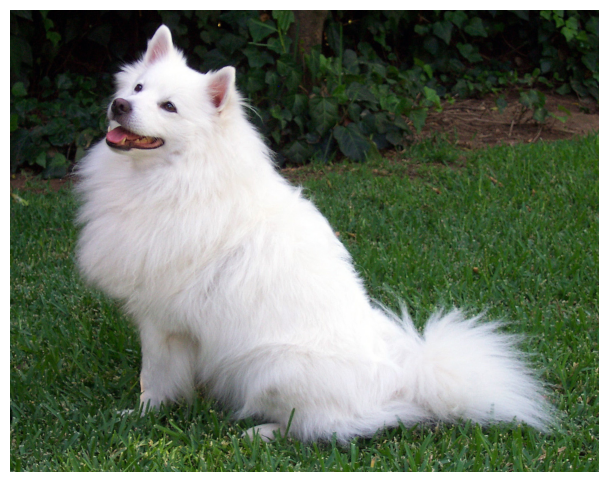

In [39]:
def display_image(url, title=None, figsize=(8, 6)):
    """Display image using matplotlib."""
    try:
        # Download image
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        
        # Convert to numpy array
        img_array = np.array(img)
        
        # Create figure and display image
        plt.figure(figsize=figsize)
        plt.imshow(img_array)
        if title:
            plt.title(title)
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Could not display image: {str(e)}")
display_image(image_url)

## Get predictions

In [49]:
# Get prediction
predicted_class, confidence, probabilities = explainer.predict(input_batch)
print(f"\nPrediction: {explainer.class_names[predicted_class]}")
print(f"Confidence: {confidence:.2%}")

# Print top 5 predictions
print("\nTop 5 predictions:")
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(5):
    class_idx = top5_catid[i].item()
    class_name = explainer.class_names[class_idx]
    prob = top5_prob[i].item()
    print(f"Class {class_idx} - {class_name}: {prob:.2%}")


Prediction: Samoyed
Confidence: 87.33%

Top 5 predictions:
Class 258 - Samoyed: 87.33%
Class 259 - Pomeranian: 3.03%
Class 270 - white wolf: 1.97%
Class 261 - keeshond: 1.11%
Class 248 - Eskimo dog: 0.92%


## Generate and visualize Guided Backpropagation


Generating Guided Backpropagation visualization...


/Users/magdam/anaconda3/envs/BeLight/lib/python3.12/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:63: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
/Users/magdam/anaconda3/envs/BeLight/lib/python3.12/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:66: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(



Shapes for Guided Backpropagation:
Input batch shape: torch.Size([1, 3, 224, 224])
Attributions shape: torch.Size([1, 3, 224, 224])
Target class: Samoyed (Confidence: 87.33%)


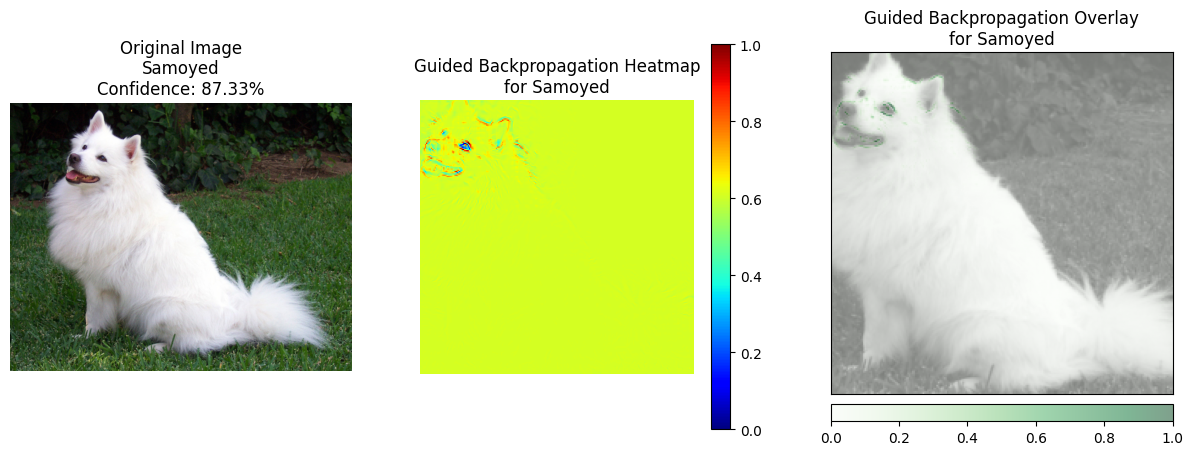

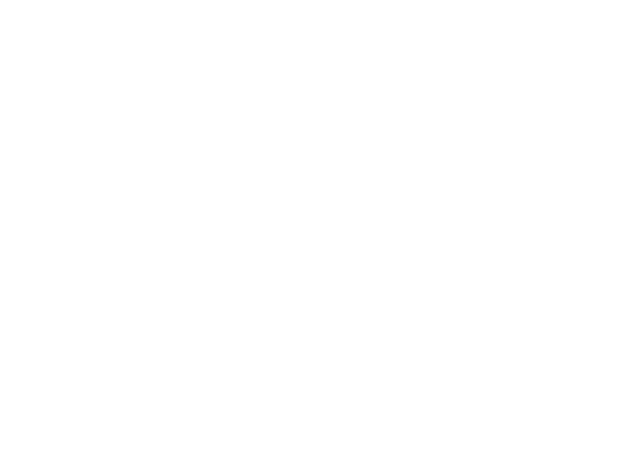

In [41]:
# Generate and visualize Guided Backpropagation
print("\nGenerating Guided Backpropagation visualization...")
guided_attr, _ = explainer.guided_backprop(input_batch)
explainer.visualize_explanations(
    input_batch, original_image, guided_attr, "Guided Backpropagation", predicted_class
)

## Generate and visualize Integrated Gradients


Generating Integrated Gradients visualization...

Shapes for Integrated Gradients:
Input batch shape: torch.Size([1, 3, 224, 224])
Attributions shape: torch.Size([1, 3, 224, 224])
Target class: Samoyed (Confidence: 87.33%)


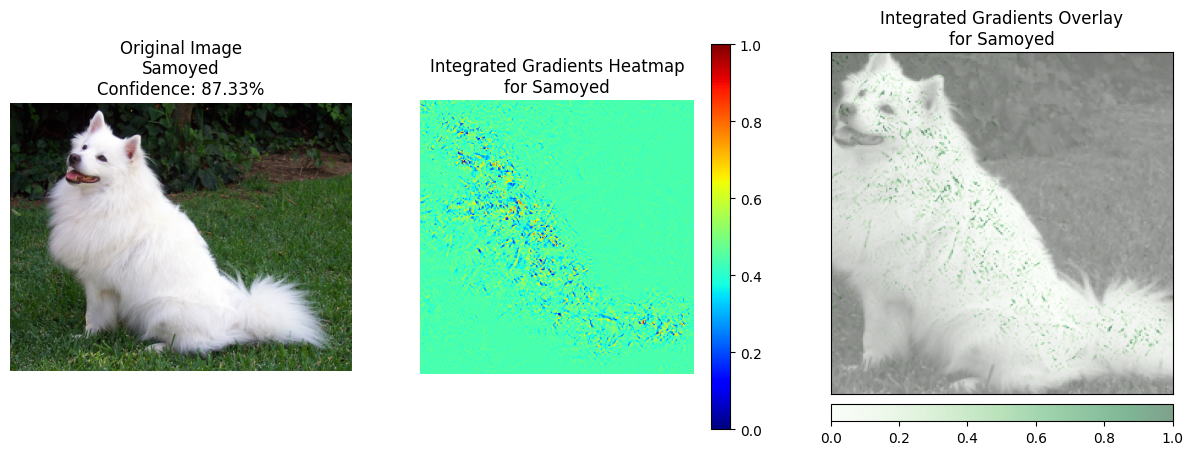

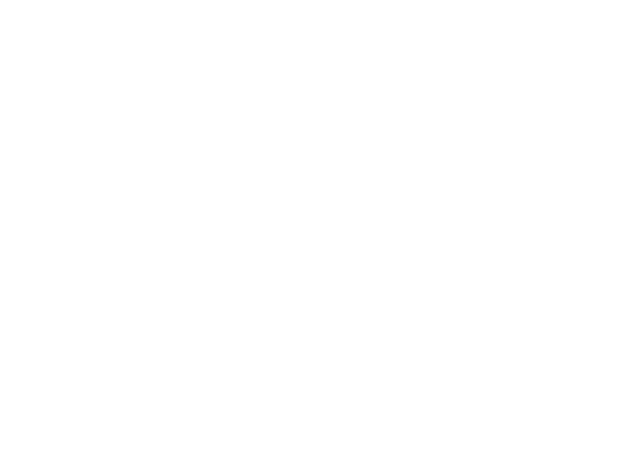

In [42]:
# Generate and visualize Integrated Gradients
print("\nGenerating Integrated Gradients visualization...")
ig_attr, _ = explainer.integrated_gradients(input_batch)
explainer.visualize_explanations(
    input_batch, original_image, ig_attr, "Integrated Gradients", predicted_class
)

## Generate and visualize GradCAM++
# TO DO: You can test different layers and predicted class


Analyzing layer: Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

Shapes for GradCAM++ (Layer Bottleneck):
Input batch shape: torch.Size([1, 3, 224, 224])
Attributions shape: torch.Size([1, 1, 7, 7])
Target class: Samoyed (Confidence: 87.33%)


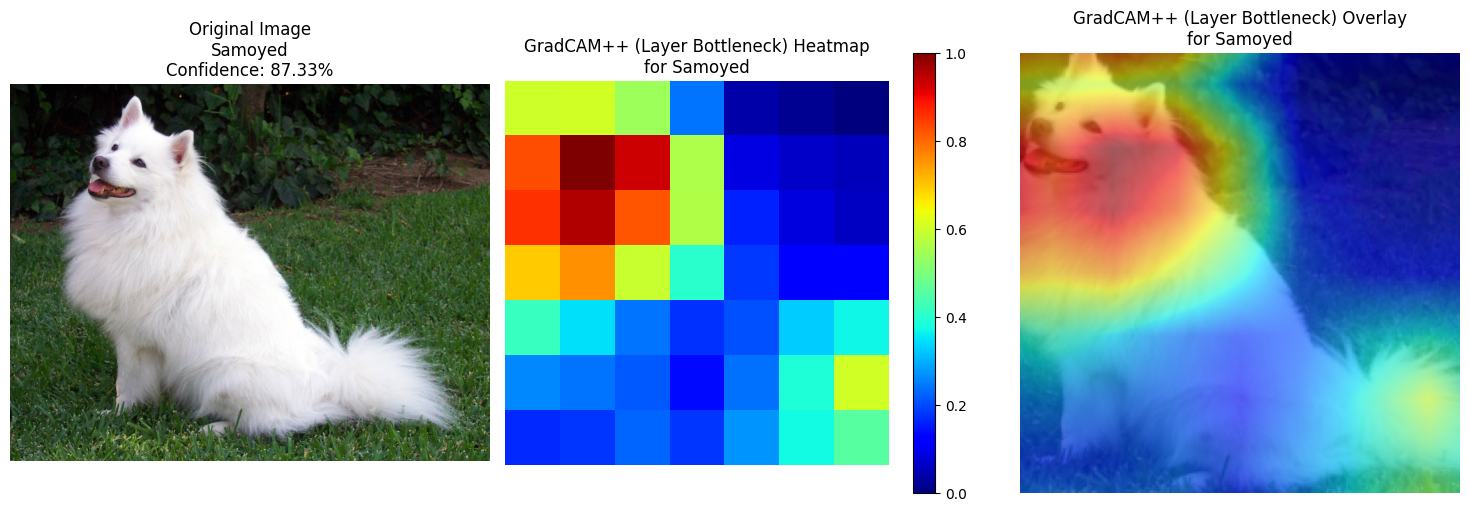

In [43]:
# You can test different layers
target_layers = [
    explainer.model.layer4[-1]  # last layer
    ## TO DO: You can test more different layers
]

for layer in target_layers:
    print(f"\nAnalyzing layer: {layer}")
    grad_cam_attr, _ = explainer.grad_cam_plus_plus(input_batch, target_layer=layer)
    explainer.visualize_explanations(
        input_batch, original_image, grad_cam_attr, 
        f"GradCAM++ (Layer {layer.__class__.__name__})", 
        predicted_class
    )

## Generate and visualize SmoothGrad CAM
# TO DO: Different parameters for SmoothGrad


SmoothGrad with parameters: {'n_samples': 10, 'stdevs': 0.15}

Shapes for SmoothGrad CAM (n=10, std=0.15):
Input batch shape: torch.Size([1, 3, 224, 224])
Attributions shape: torch.Size([1, 1, 7, 7])
Target class: Samoyed (Confidence: 87.33%)


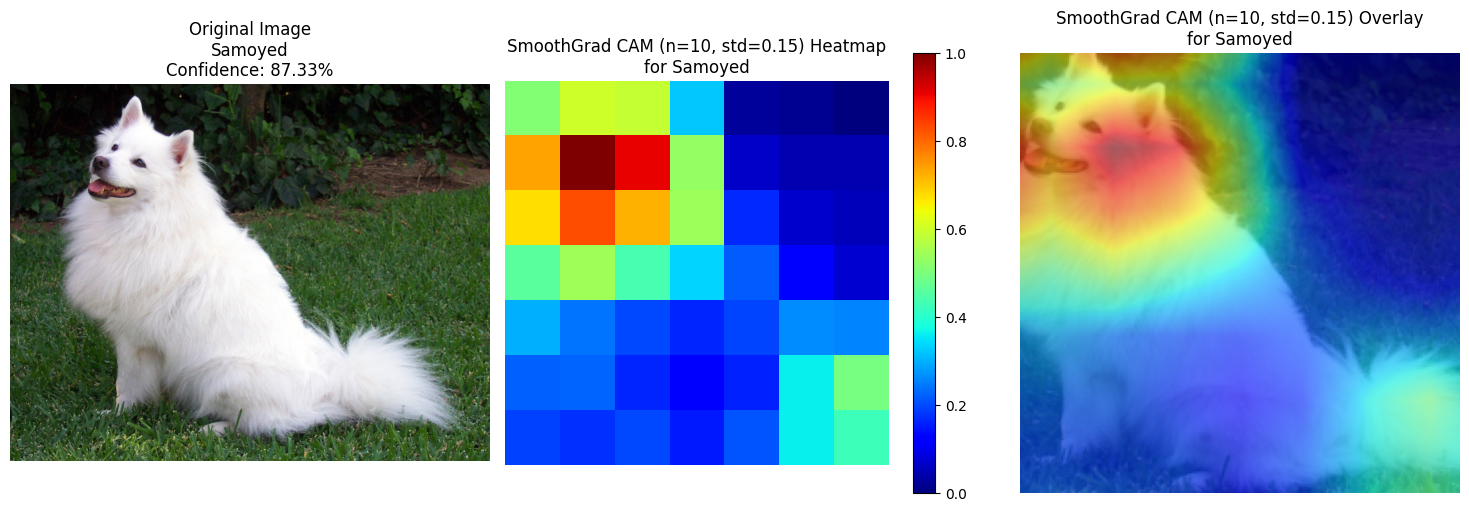

In [44]:
 # Different parameters for SmoothGrad
smooth_grad_params = [
    {'n_samples': 10, 'stdevs': 0.15}
    ## TO DO: You can test more different parameters
]

for params in smooth_grad_params:
    print(f"\nSmoothGrad with parameters: {params}")
    smooth_grad_attr, _ = explainer.smooth_grad_cam(
        input_batch, 
        predicted_class,
        n_samples=params['n_samples'],
        stdevs=params['stdevs']
    )
    explainer.visualize_explanations(
        input_batch, original_image, smooth_grad_attr,
        f"SmoothGrad CAM (n={params['n_samples']}, std={params['stdevs']})",
        predicted_class
    )

## Generate and visualize Score CAM


Generating Score CAM visualization...

Shapes for Score CAM:
Input batch shape: torch.Size([1, 3, 224, 224])
Attributions shape: torch.Size([1, 3, 224, 224])
Target class: Samoyed (Confidence: 87.33%)


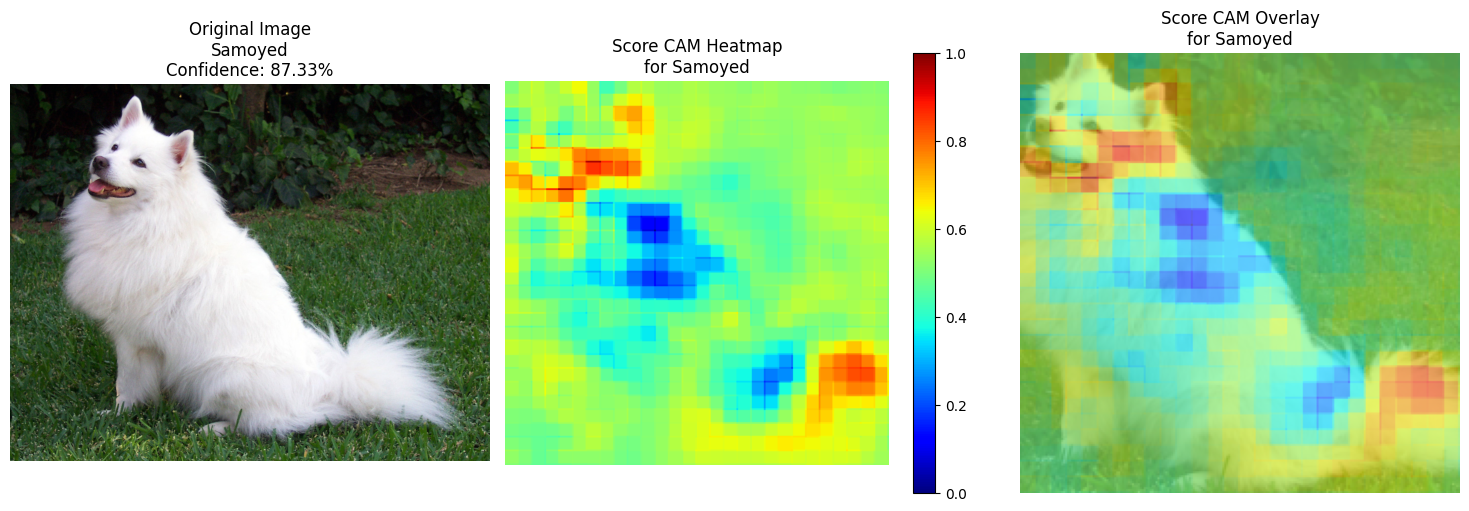

In [45]:
# Generate and visualize Score CAM
print("\nGenerating Score CAM visualization...")
score_cam_attr, _ = explainer.score_cam(input_batch, predicted_class)
explainer.visualize_explanations(
    input_batch, original_image, score_cam_attr, "Score CAM", predicted_class
)